<a href="https://colab.research.google.com/github/slowings/Phase_4_Final_Project/blob/main/Phase_4_Final_Project_ModelAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive


## Data Visualization and Preprocessing
In this section we'll take a preliminary look at our data to get a feel for what we're working with.  We'll examine the numbers of normal and infected patients in the train, test and val sets to check for class imbalances, plot a random sample of xrays from our train set,  and determine our course of action for preprocessing.  This will likely involve resizing our data, binary encoding our target variable, and augmenting our data.

Let's begin by taking a look at the contents of our data directory

In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'sample_data']


In [4]:
# Set path to xrays
drive_path = '/gdrive/MyDrive/Data/archive.zip'


In [5]:
# Navigate to xrays
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'archive.zip', 'sample_data']


In [6]:
# Unzip images
!unzip -q 'archive.zip'

### Check distribution
Now that we've confirmed the file path and unzipped our data, let's take a moment to create our paths to our data, and then double check the distribution of 'normal' vs. 'pneumonia' xrays in the train, test, and val directories to ensure all our files loaded properly

In [7]:
# Define paths to train, test and val sets
train_folder = '/content/chest_xray/train'
train_pneu = '/content/chest_xray/train/PNEUMONIA'
train_norm = '/content/chest_xray/train/NORMAL'

test_folder = '/content/chest_xray/test'
test_pneu = '/content/chest_xray/test/PNEUMONIA'
test_norm = '/content/chest_xray/test/NORMAL'

val_folder = '/content/chest_xray/val'
val_pneu = '/content/chest_xray/val/PNEUMONIA'
val_norm = '/content/chest_xray/val/NORMAL'

# Print distribution
print('Train PNEUMONIA= ', len(os.listdir(train_pneu)))
print('Train NORMAL= ', len(os.listdir(train_norm)))

print('Test PNEUMONIA= ', len(os.listdir(test_pneu)))
print('Test NORMAL= ', len(os.listdir(test_norm)))

print('Val PNEUMONIA= ', len(os.listdir(val_pneu)))
print('Val NORMAL= ', len(os.listdir(val_norm)))


Train PNEUMONIA=  3875
Train NORMAL=  1341
Test PNEUMONIA=  390
Test NORMAL=  234
Val PNEUMONIA=  8
Val NORMAL=  8


In [ ]:
# Confirm varied image size by taking samples and printing shape
image_path = '/content/chest_xray/train/PNEUMONIA'

# Get the list of images in the dataset
image_files = os.listdir(image_path)

# Get the first image file
first_image_file = image_files[0]

# Load the image using OpenCV
image = cv2.imread(os.path.join(image_path, first_image_file))

# Get the dimensions of the image
height, width, channels = image.shape

print("Image Width:", width)
print("Image Height:", height)
print("Number of Channels:", channels)

Image Width: 668
Image Height: 375
Number of Channels: 3


### Preprocessing

In [8]:
# Import Statements

import time
import scipy
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

### Generate Augmented Tensors
Below we'll create our dataframes of our augmented, rescaled and resized images, begining with defining the architecture of our augemnted ImageGenerator, which, just as before,  we'll use to read in our data in batches, normalizing pixel output, scaling images, converting to greyscale, and setting to the binary class mode for our target variable, y.

In [9]:
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [10]:
# get all the data in the "train" directory (5216 images), rescale and reshape them
train_generator = image_gen.flow_from_directory(
        train_folder,
        target_size=(150, 150), batch_size=5216,
        class_mode='binary',
        color_mode = 'grayscale',
        seed=18)

# get all the data in the "test" directory (624 images), rescale and reshape them
test_generator = test_data_gen.flow_from_directory(
        test_folder,
        target_size=(150, 150), batch_size = 624,
        class_mode='binary',
        shuffle=False,
        color_mode = 'grayscale',
        seed=18)

# get all the data in the "split/validation" directory (16 images), rescale and reshape them
val_generator = test_data_gen.flow_from_directory(
        val_folder,
        target_size=(150, 150), batch_size = 16,
        class_mode='binary',
        color_mode = 'grayscale',
        seed=18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Batch feed and join images/labels to create data sets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [12]:
# Explore dataset again to ensure all files are there and in desired shape
print ("Train_images shape: " + str(X_train.shape))
print ("Train_labels shape: " + str(y_train.shape))
print ("Test_images shape: " + str(X_test.shape))
print ("Test_labels shape: " + str(y_test.shape))
print ("Val_images shape: " + str(X_val.shape))
print ("Val_labels shape: " + str(y_val.shape))

Train_images shape: (5216, 150, 150, 1)
Train_labels shape: (5216,)
Test_images shape: (624, 150, 150, 1)
Test_labels shape: (624,)
Val_images shape: (16, 150, 150, 1)
Val_labels shape: (16,)


## Final CNN: 6th model
Convolutional Neural networks, or CNN's were inspired by the workings of the visual cortex in human and animal brains, in which images are processed by simple cells which sample small areas of the visual field and register linear elements, and complex cells, with larger receptive feilds that take in position of those edges relative to the edges of the feild. Similarly, a CNN identifies linear elements in images through convolution (mapping the highest values of a pixel in a given sector of our image) and pooling (shrinking an image to reduce its pixel density). Because of this, they perform exceptionally well with image classification, and are an excellent tool for medical analysis.

In the next section we'll start by building a  CNN to classify our adapted xrays, in the  final iteration of our model.


In [14]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [13]:
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [15]:
# inspect the shape of our model before fitting/training it and see how many training parameters we have
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [17]:
history = model.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=20,
                       callbacks= [learning_rate_reduction],
                       validation_data=(X_val, y_val))

Epoch 1/20
261/261 [==============================] - 16s 15ms/step - loss: 0.5139 - accuracy: 0.8449 - val_loss: 1.0713 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
261/261 [==============================] - 3s 13ms/step - loss: 0.2583 - accuracy: 0.9026 - val_loss: 0.9461 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
261/261 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.9220
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
261/261 [==============================] - 3s 13ms/step - loss: 0.2121 - accuracy: 0.9220 - val_loss: 0.7538 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
261/261 [==============================] - 3s 13ms/step - loss: 0.1271 - accuracy: 0.9549 - val_loss: 0.8601 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/20
258/261 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9657
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
261/261 [=============================

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [19]:
def visualize_CNN_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['accuracy', 'val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test < thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Model Confusion Matrix')
  plt.show()



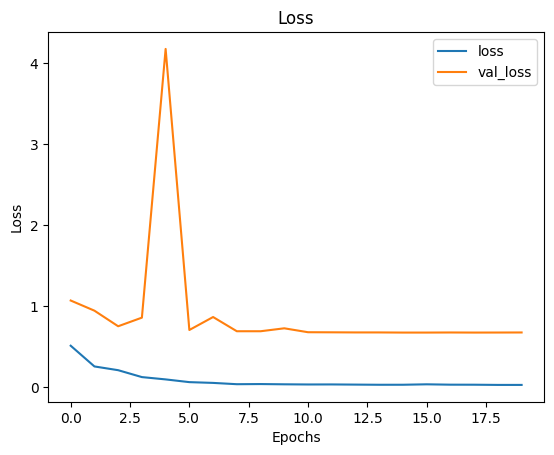

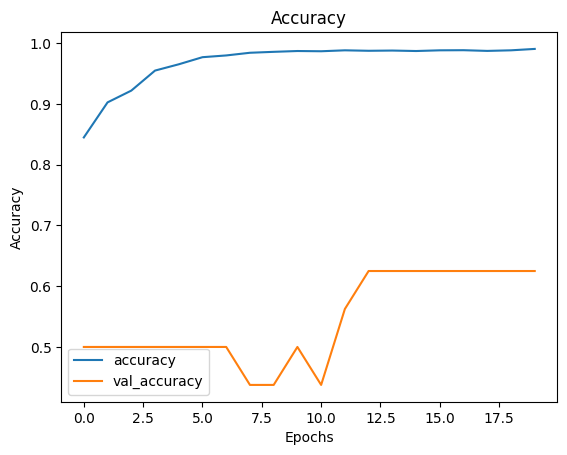

20/20 [==============================] - 0s 4ms/step


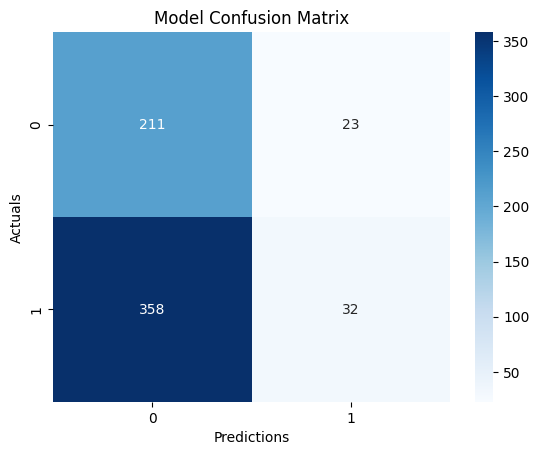

In [20]:
visualize_CNN_results(history)